In [1]:
%matplotlib inline
import scipy.io as sio
import numpy as np
import os
import math
import matplotlib.pyplot as plt

# need to install statsmodels from conda-forge
import statsmodels.api as sm

device = 'mps'

This notebook shows how to load and fit a GLM to data from the CRCNS-ret1 dataset, available <a href=https://crcns.org/data-sets/retina/ret-1/about-ret-1>here</a>.

Additional useful background information about the data can be found <a href=https://crcns.org/files/data/ret-1/crcns_ret-1_data_description.pdf>here</a>.

## Loading Data
First up, we'll load the data. For the retinal ganglion cell dataset, data is in two .mat files: the first (`20080516_R1.mat`) contains spike times and stimulus information. The second file (`stimulus.mat`) contains the actual visual stimulus that was presented to neurons.

**Note**: `20080516_R1.mat` contains spiking data from **three** trials, but `stimulus.mat` only contains the stimulus used on the first of these three trials! So make sure you only use spiking data from trial zero when computing your cells' receptive field.

In [2]:
data = sio.loadmat('../../data/20080516_R1.mat',struct_as_record=False,squeeze_me=True)
i = 0 # trial number (we'll only consider the first trial for now)

# load the stimulus presented on trial 0:
stim = sio.loadmat('../../data/stimulus.mat',struct_as_record=False,squeeze_me=True)

### Contents of `stimulus.mat` file
The variable `stim` is a dict with one field of interest, named `r`. `r` is an 640 x 89899 matrix describing the stimulus presented on the first trial: in this case, a set of 640 stacked bars that are either black (=-1) or white (=1) are projected onto the retina; the color of each bar is randomly sampled on each of 89899 time steps, or "frames".

<img src="https://drive.google.com/uc?export=view&id=1rm9Oakc7vkoM7T_KxZZ-9laO-rjXu7b8" alt="example stimulus" style="width: 500px;"/>

The 640 rows of `r` correspond to the 640 stacked bars, while the 89898 columns of `r` correspond to bar color on each frame. Information about the duration of stimulus time steps, the actual size of the bars, etc, is contained in `data['stimulus']`, see below.

### Contents of the data `.mat` file
The `data` dict contains three variables:
 - `stimulus` is a 3-dimensional matlab struct of metadata about the stimulus on each of the 3 trials. Metadata includes the framerate (`stimulus(1).frame`), stimulation start time in seconds relative to recorded neural spiking (`stimulus(1).onset`), number of stimuli (frames) presented (`stimulus(1).Nframes`), etc
 - `spikes` is a 7 x 3 matlab cell array of vectors, giving the spike times of each of 7 neurons on each of 3 trials. So, eg, in Matlab `spikes{3,1}` gives the times (in seconds) that neuron 3 spiked on the first trial (keep in mind that Matlab uses 1-indexing while python uses 0-indexing)
 - `datainfo` contains more general metadata about the experiment (neural types/animal lines used, experiment date, experimenter name, etc)
 
Now that we've loaded the raw data, we need to get it into a usable format for GLM analysis. To start, we'll unpack our variables of interest from `data` and `r`, and keep only the data from trial `i`:

In [3]:
# i is set to 0 for the first trial
stimulus = data['stimulus'][i]
spikes   = data['spikes'][:,i] # so eg spikes[0] is all spike times (in seconds) for neuron 1 on trial i, while 
                               # spikes[2][9] is the time of the 10th spike from the 3rd neuron on trial i
datainfo = data['datainfo']

r = stim['r']

## Formatting Data
Let's take a look at the contents of `stimulus` for the first trial:

In [4]:
{key: value for key, value in stimulus.__dict__.items()}

{'_fieldnames': ['type', 'onset', 'frame', 'Nframes', 'pixelsize', 'param'],
 'type': 'binarywhitenoise',
 'onset': 1.2375,
 'frame': 0.016671788281371697,
 'Nframes': 89899,
 'pixelsize': 8.3,
 'param': <scipy.io.matlab._mio5_params.mat_struct at 0x7face902beb0>}

As you can see, frames are presented every `stimulus.frame` = 0.01667 seconds, and the first frame is presented at `stimulus.onset` = 1.2375 seconds after the start of neural recording, and each of the 640 rows is `stimulus.pixelsize` = 8.3 microns high.

First, we need to address the fact that our spike times are in **seconds** but our stimulus matrix `r` is in units of frames. To get everything into a common set of units, we'll create a vector `time` giving the time at which each stimulus frame was presented:

In [5]:
# stimulus.frame is dt (time per bin or frame)
time = np.arange(0,stimulus.Nframes) * stimulus.frame + stimulus.onset
N = len(time)-1

Now we use this vector `time` to get spikes and stimuli into the same time units. In our case, the easiest approach is to convert spike times into units of stimulus frames. What this means is rather than reporting the timing of each spike in seconds/ms, we'll report the **number** of spikes that each stimulus frame evoked.

The only next step is realizing that the number of spikes occurring between the start of frame $t$ and the start of frame $t+1$ is exactly what we get if we use Numpy's `histogram` function to bin spikes with bin-edges defined by our vector `time`:

In [6]:
spikeCounts = np.zeros((7,len(time)-1))
for cellnum in range(0,7):
    spikeCounts[cellnum,:],_ = np.histogram(spikes[cellnum],time) 
# coding note: np.histogram returns a second tuple, which is just the bin edges. We already know what these are 
# (because we specify them in the vector TIME) so we use "_" as a variable name to ignore this second term.

Fitting a GLM is similar in spirit to regression. We have one **dependent variable** (neuron spiking) which we would like to explain as a function of multiple **independent variables** (features of the stimulus that was presented to the retina). So in GLM fitting, we'll provide the model with a set of independent variables, and allow the GLM to assign **weights** to those variables that are good predictors of spiking activity.

That is, we're looking for the values of $w$ that best satisfy:

\begin{equation} spikeCounts[t] = f(\sum_{i=1}^N w_i \cdot \textrm{independent variable}_i[t])\end{equation}

where $f$ is a nonlinear linking function (see slides from 2/1).

### Choosing our independent variables (aka regressors)
In principle, the independent variables could be anything! But we have a hunch of what good predictors of cell spiking should be: this is a cell in the retina, so it probably is spiking as a function of BOTH:
 - stimulus intensity (probably only in a subset of the stimulus space)
 - stimulus history (a lot of retinal neurons respond to ON/OFF events: eg a patch of space changing from dark to bright, or vice versa)
 
Luckily we know what both of these are. Let's say we want to look at the stimulus that evoked a spike occurring at a given time $t$. We don't know much about which of the 640 stimulus bars this neuron "sees", but we think that the past 3 frames of the stimulus are what matter for predicting spiking. This assumption, written mathematically, is saying that
\begin{eqnarray} spikeCounts[t] &=& f(w_1 \cdot r[0,t] + w_2 \cdot r[1,t] + ... + w_{640} \cdot r[639,t] \\
                    && \quad + w_{641} \cdot r[0,t-1] + ... + w_{1280} \cdot r[640,t-1] \\
                    && \quad + w_{1281} \cdot r[0,t-2] + ... + w_{1920} \cdot r[640,t-2])
\end{eqnarray}
or, in matrix notation:
\begin{equation} spikeCounts[t] = f( w \cdot \left[ \begin{array}{c}r[:,t]\\r[:,t-1]\\r[:,t-2]\end{array} \right] )\end{equation}

where $w$ is now a 1 x 1920 vector.

### Fitting multiple observations
Taken alone this is obviously under-constrained (1 equation with 1920 unknowns!) but we are looking for a set of $w$'s that explains not only the spiking at time $t$, but the spiking at all times during the experiment (up to 89898 equations with 1920 unknowns- one equation for each *observation*, that is for each stimulus frame presented). Let's say we want to specifically use frames 100-50,100 to fit our $w$'s- then we are solving a set of 50,000 equations:

\begin{eqnarray}
spikeCounts[100] &=& f( w \cdot \left[ \begin{array}{c}r[:,100]\\r[:,99]\\r[:,98]\end{array} \right]) \\
spikeCounts[101] &=& f( w \cdot \left[ \begin{array}{c}r[:,101]\\r[:,100]\\r[:,99]\end{array} \right]) \\
&& ...\\
spikeCounts[50100] &=& f( w \cdot \left[ \begin{array}{c}r[:,50100]\\r[:,50099]\\r[:,50098]\end{array} \right])\\
\end{eqnarray}

Again, this can be written in matrix notation as:
\begin{equation}
spikeCounts[100:50100] = f( w \cdot \left[ \begin{array}{c}r[:,100:50100]\\r[:,99:50099]\\r[:,98:50098]\end{array} \right])
\end{equation}

### Translating this to code
In practice, `sm.GLM.fit()` does the heavy lifting of finding the maximum-likelihood-estimate $w$'s for us: all we need to do is provide it with the **dependent** and **independent** variables-- here `spikeCounts` and corresponding frames of `r`. The only step left to do is to convert `r` into a format like the above equations- where for each frame $t$, `sm.GLM.fit()` is given `r` over some spatial range of interest (all 640 bars in the example above- or a subset of those bars in the code below, to reduce runtime) and some temporal history window of interest.

Let's say we're fitting the response of the first neuron (`trainCell=0`), and for simplicity we only care about the past 10 frames of the stimulus, and we only care about bars 180-220 (we cheated and looked at the spike-triggered-average to see that this is roughly where this receptive field lies.) Then we can create `shiftedData`, a "stacked" version of `r`:

In [7]:
# create shifted version of your input
# (e.g. time-embedding)
# stim --> spikes
# data['spikes'] --> 7 neurons x 3 trials x T timepoints (different per trial)
# X:
#    last 10 frames of stim
#    bars 180-220 (where the receptive field lies)
# Y:
#    spikeCounts

# stack 10 frames for each timestep onto each row

stim_we_care_about = stim['r'][175:215,:].T
shiftedData = np.zeros((89898,400))

for i in range(10, stim_we_care_about.shape[0]):
    shiftedData[i,:] = stim_we_care_about[i-10:i,:].reshape(1,400)

y = spikeCounts[0,:]
shiftedData = sm.add_constant(shiftedData) # need to add a constant for the GLM

shiftedData.shape, spikeCounts[0,:].shape

((89898, 401), (89898,))

Now that we have `shiftedData`, our only remaining task is to pick which range of timepoints we'll use to fit our model, and to subsample our data down to this range. (We also might have to transpose `shiftedData` to get it in the right format for `sm.GLM.fit()`). Also, we want to add a constant offset term to our model if that's not included by default:

We're all set! Now the only job is to initialize a GLM with a Poisson (or some other format) linking function, and then fit this model to our data. If you don't like the Poisson linking function, there are a couple others you can try- call `dir(sm.families)` to see a full list.

In [8]:
# subsample data and apply  transformations if needed
# create and fit the GLM
# https://scikit-learn.fondation-inria.fr/generalized-linear-models-have-landed-in-scikit-learn/
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html#sklearn.linear_model.PoissonRegressor
dir(sm.families)
glm = sm.GLM(y, shiftedData, family=sm.families.Poisson())
#glm = sm.GLM([0,0,1,1], [[1,1,1],[0,1,1],[0,1,0],[1,0,0]], family=sm.families.Poisson())
myFit = glm.fit()
print(myFit.summary2())

                Results: Generalized linear model
Model:              GLM              AIC:            141793.8926 
Link Function:      Log              BIC:            -948502.2774
Dependent Variable: y                Log-Likelihood: -70496.     
Date:               2023-01-05 17:13 LL-Null:        -76046.     
No. Observations:   89898            Deviance:       72339.      
Df Model:           400              Pearson chi2:   7.54e+04    
Df Residuals:       89497            Scale:          1.0000      
Method:             IRLS                                         
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -0.9738     0.0057   -169.9937   0.0000   -0.9851   -0.9626
x1       0.0037     0.0051      0.7349   0.4624   -0.0062    0.0137
x2      -0.0011     0.0051     -0.2110   0.8329   -0.0110    0.0089
x3       0.003

## Evaluating your fit model
So you've fit a GLM- now what? How can we tell if we've done a good job of modeling this neuron? We have a couple options for evaluating goodness of fit.

### Looking at the fit parameters
First off, it would be good to see if our fit model produces anything that looks like a reasonable estimate of a cell's receptive field. If you've computed a spike-triggered average for your neuron, you can compare this to the stimulus filter fit by the GLM.

The parameters of our fit GLM are found in `myFit.params`, and there are $[$ `winSize` $*$ `len(spaceRange)` $ + 1 ]$ of them ($+1$ because of the constant offset term we appended to our independent variables.) As you can see from `myFit.summary2` above, this constant offset term is our first model parameter, and the rest correspond to our input variables.

These parameters are weights on the data in `shiftedData`, which we constructed as blocks of pixel space at multiple offsets in time. So if we reshape these weights into a `winSize` $*$ `len(spaceRange)` matrix, we should get something that looks like the neuron's spatiotemporal receptive field:

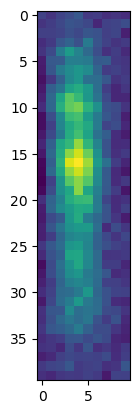

In [9]:
# make a plot of the receptive field based on your model's fit weights!
plt.figure()
plt.imshow(myFit.params[1:].reshape(10,40).T)
plt.show()

Looking good! But you might use this to go back and adjust `spaceRange` or `winSize` to make sure you're using the right spatial and temporal windows for fitting- for instance, to make sure we're not chopping off the top of this cell's receptive field with our chosen `spaceRange`.

### Predicting spiking on held-out data

We might also ask how well our model is able to predict the spiking of the neuron. Since we fit the model using just the frames in `trainInds = np.arange(100,10000)`, we can use the remaining held-out frames as a test set:

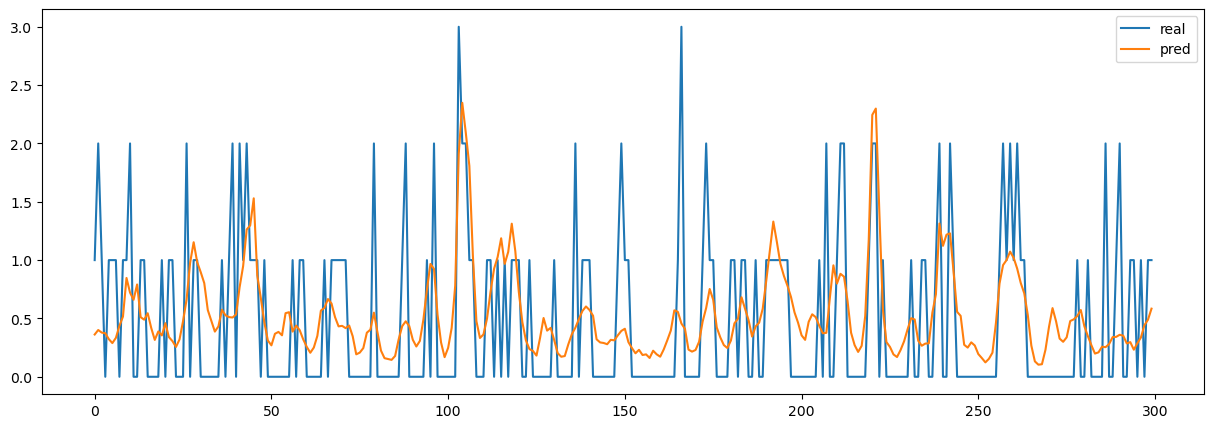

In [10]:
# simulated GLM response to a test set of frames
start = 2000
length = 300

plt.figure(figsize=(15,5))
plt.plot(spikeCounts[0, start:start+length], label='real')
plt.plot(myFit.predict(shiftedData[start:start+length]), label='pred')
plt.legend()
plt.show()

### Quantifying goodness of fit
How to evaluate model fit could be a whole course in itself. Comparing goodness of fit of different models is how you'll decide what factors best explain your data: in general, our goal is to maximize the value of the data likelihood, while also not including unnecessary parameters in your model. Here are a few quick ways to assess and refine your model.

#### - Using `myFit.deviance`
You might be inclined to compute the **mean squared error**, $MSE = \sum_{t=1}^T(y_t - \hat{y}_t)^2 = \sum($ `spikeCounts_truth` $-$ `spikeCounts_pred` $)^2$, to quantify how far your model's prediction is from reality. MSE is appropriate *only* if your data is Normally distributed- unless you chose a Gaussian linking function for your GLM, this is probably not the case.

Instead, a more general form of the MSE is the model <a href=https://en.wikipedia.org/wiki/Deviance_(statistics)>**deviance**</a>, which measures how far your model's predictions are from a "saturated" model-- a model that has one parameter for every observation, and hence can fit the data perfectly. Deviance is defined as

\begin{equation}
\textrm{Deviance} = 2*(\mathcal{LL}(\textrm{saturated model}) - \mathcal{LL}(\textrm{your fit model}))
\end{equation}

where $\mathcal{LL}$ is the log-likelihood of the data given the model. (Athough strangely, some sources seem to use "deviance" to refer simply to the quantity $-2\mathcal{LL}(\textrm{fit model})$.)

#### - Using `myFit.AIC` or `myFit.BIC`
AIC and BIC are the <a href=https://en.wikipedia.org/wiki/Akaike_information_criterion>Akaike Information Criterion</a> and the <a href=https://en.wikipedia.org/wiki/Bayesian_information_criterion>Bayesian Information Criterion</a>. Unlike Deviance, these values take into account both goodness of fit and number of parameters used. Lower values of these criteria means you've done a better job of fitting your data- either by increasing your data likelihood, or by decreasing the number of parameters in your model. The BIC is defined as

\begin{equation}
\textrm{BIC} = \ln(n)k - 2 \mathcal{LL}
\end{equation}

where $n$ is the number of observations (time frames) fit, $k$ is the number of parameters used in fitting, and $\mathcal{LL}$ is again the log-likelihood of the data given the model. So you can get a lower BIC either by *fitting the same data with fewer parameters*, OR by *increasing your data likelihood* (ie the quality of your fit).

 - Note: the `statsmodel` toolbox instead computes $\textrm{BIC} = \mathcal{D} - (n-k-1)\ln(n)$, where $\mathcal{D}$ is the model deviance (close to, but not the same as, $-2\mathcal{LL}$). But the *net effect* is the same: BIC will be smaller for smaller numbers of parameters ($k$) or for higher log-likelihood ($\mathcal{LL}$). But because of the big $-n\ln(n)$ term, `statsmodel` usually gives large negative values of BIC, whereas if you compute it yourself/in Matlab using the original formula, you'll tend to get positive values.

#### - Using p-values of independent variables
Your fit GLM also reports a p-value for the weight assigned to each independent variable. Like in other statistical tests, low p-values tell you that the predictive power of that IV for the data is *significantly better than chance*. For example, a p-value <0.05 tells you that if you randomly generated an independent variable, its fit to the dependent variable would be better than your IV less than 5% of the time.

One use of p-values might be to choose the value of `winSize`, or to determine whether additional model variables (like a spike-history term or between-neuron weight) make a significant contribution to improving model predictions.

72339.07539682815


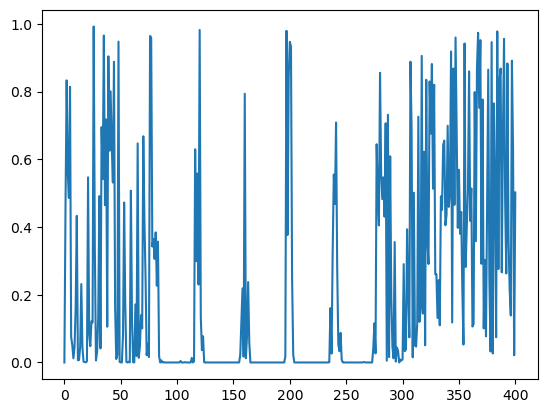

In [11]:
print(myFit.deviance)
plt.figure()
plt.plot(myFit.pvalues)
plt.show()

## Bells and whistles

Here are a few extensions of our basic GLM, where we add in other independent variables to the model to see if they improve model performance.

### Adding a spike-history term
Often a cell's probability of spiking at time $t$ is dependent on whether or not it spiked in the recent past: for instance, a neuron might have a refractory period, or might always fire off bursts of multiple spikes at a time. A spike history term lets us capture these dynamics in our model.

If our original model was

\begin{equation}
spikeCounts[100:50100] = f( w \cdot \left[ \begin{array}{c}r[:,100:50100]\\r[:,99:50099]\\r[:,98:50098]\end{array} \right])
\end{equation}

then adding in a term allowing the model to change the probability of spiking if the cell fired in the last time bin gives us:

\begin{equation}
spikeCounts[100:50100] = f( w \cdot \left[ \begin{array}{c}r[:,100:50100]\\r[:,99:50099]\\r[:,98:50098]\\spikeCounts[99:50099]\end{array} \right])
\end{equation}

as with the stimulus model, we can also make spiking depend on multiple past time bins, eg

\begin{equation}
spikeCounts[100:50100] = f( w \cdot \left[ \begin{array}{c}r[:,100:50100]\\r[:,99:50099]\\r[:,98:50098]\\spikeCounts[99:50099]\\spikeCounts[98:50098]\\spikeCounts[97:50097]\end{array} \right])
\end{equation}

etc. Try implementing this in your model!

In [16]:
# make a spike history regressor and include it in your model, and re-fit
# add spike history as an additional feature to the shiftedData
stim_we_care_about = stim['r'][175:215,:].T
X = np.zeros((89898,410))
y = spikeCounts[0,:]

# add the last 10 stims
for i in range(10, stim_we_care_about.shape[0]):
    X[i,:400] = stim_we_care_about[i-10:i,:].reshape(1,400)

# add the last 10 spikes as well
for i in range(10, len(y), 10):
    X[i,400:] = y[i-10:i]

X = sm.add_constant(X) # need to add a constant for the GLM

X

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1., -1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1., -1., ...,  0.,  0.,  0.]])

In [13]:
# fit the model
glm = sm.GLM(y, shiftedData, family=sm.families.Poisson())
#glm = sm.GLM([0,0,1,1], [[1,1,1],[0,1,1],[0,1,0],[1,0,0]], family=sm.families.Poisson())
myFit = glm.fit()
print(myFit.summary2())

                Results: Generalized linear model
Model:              GLM              AIC:            141793.8926 
Link Function:      Log              BIC:            -948502.2774
Dependent Variable: y                Log-Likelihood: -70496.     
Date:               2023-01-05 17:13 LL-Null:        -76046.     
No. Observations:   89898            Deviance:       72339.      
Df Model:           400              Pearson chi2:   7.54e+04    
Df Residuals:       89497            Scale:          1.0000      
Method:             IRLS                                         
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -0.9738     0.0057   -169.9937   0.0000   -0.9851   -0.9626
x1       0.0037     0.0051      0.7349   0.4624   -0.0062    0.0137
x2      -0.0011     0.0051     -0.2110   0.8329   -0.0110    0.0089
x3       0.003

We can now unpack both the stimulus filter and the spike-history filter from our fit weights:

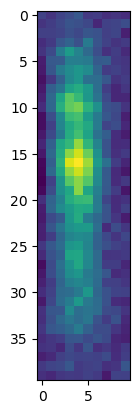

In [17]:
# plot the fit weights that make up the stimulus filter and the spike-history filter
# make a plot of the receptive field based on your model's fit weights!
plt.figure()
plt.imshow(myFit.params[1:401].reshape(10,40).T)
plt.show()

Our fit spike-history filter (right) shows that there's a slight refractory period following a spike. It currently looks a bit noisy, but this will improve if you use more data for your fit.

Finally, let's compare spiking predictions with and without the spike-history term:

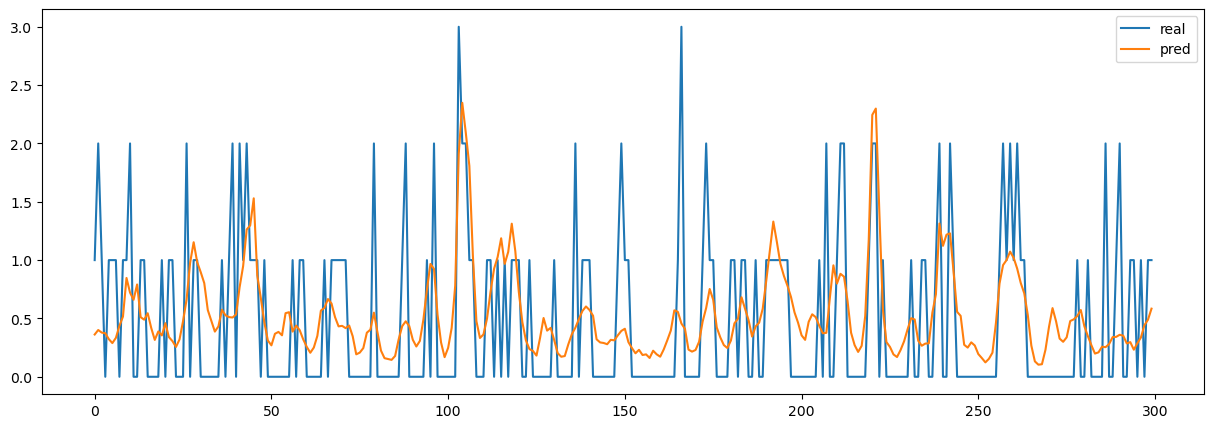

In [18]:
# predict spiking from the two version of the GLMs
# simulated GLM response to a test set of frames
start = 2000
length = 300

plt.figure(figsize=(15,5))
plt.plot(spikeCounts[0, start:start+length], label='real')
plt.plot(myFit.predict(shiftedData[start:start+length]), label='pred')
plt.legend()
plt.show()